In [2]:
cd /home

/home


In [3]:
import matplotlib.pyplot as plt

from src.models.astromer_0 import get_ASTROMER 
from src.data.zero import pretraining_pipeline

from mpl_toolkits.axes_grid1 import make_axes_locatable

2024-03-15 01:48:18.832707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
probed = 0.9
random = 0.
same   = 0.
window_size = 200

loader = pretraining_pipeline('./data/records/alcock/fold_0/alcock_20/train/',
                              batch_size= 32, 
                              window_size=window_size,
                              shuffle=True,
                              sampling=True,
                              repeat=1,
                              msk_frac=probed,
                              rnd_frac=random,
                              same_frac=same)

[INFO] Sampling random windows
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-03-15 01:48:19.966641: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: UNKNOWN ERROR (34)
2024-03-15 01:48:19.966668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: b2d7e74a0f3b
2024-03-15 01:48:19.966675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: b2d7e74a0f3b
2024-03-15 01:48:19.966768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-03-15 01:48:19.966796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.199.2
2024-03-15 01:48:19.967000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  

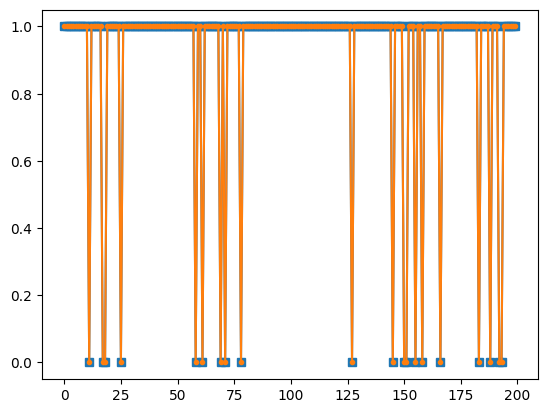

In [5]:
plt.figure()
for x, y in loader.take(1):
    x_input = x['input'][0]
    x_times = x['times'][0]
    x_maski = x['mask_in'][0]
    x_masko = y['mask_out'][0]
    
    cond = x_maski == x_masko
    
    plt.plot(x_maski, label='in', marker='s')
    plt.plot(x_masko, label='out', marker='.')

In [6]:
import tensorflow as tf 

from src.models.astromer_0 import positional_encoding
from src.models.astromer_0 import MultiHeadAttention 

from tensorflow.keras.layers import Dense, TimeDistributed, Dropout

In [7]:
for x, y in loader.take(1):
    # Input Transformer + PE
    x_pe = positional_encoding(x['times'], 256, mjd=True)
    x_transformed = Dense(256)(x['input'])
    transformed_input = x_transformed + x_pe
    transformed_input = Dropout(0.)(transformed_input)
    
    # Encoder layer 
    
    attn_output, w, qkvalues = MultiHeadAttention(256, 4, -1000000, 'QK')(transformed_input, mask=x['mask_in'])
    
    

[INFO] Using PE with c: 2.0
[INFO] Using masked-att with alpha = -1000000.00
[INFO] Masking Query and Key tokens


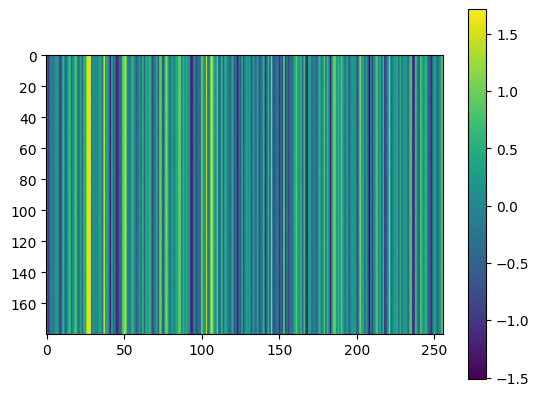

In [8]:
att_mask = tf.boolean_mask(attn_output[0], x['mask_in'][0,...,0])

plt.imshow(att_mask)
plt.colorbar()

Text(0.5, 1.0, 'S(QK - $\\infty$M)*V')

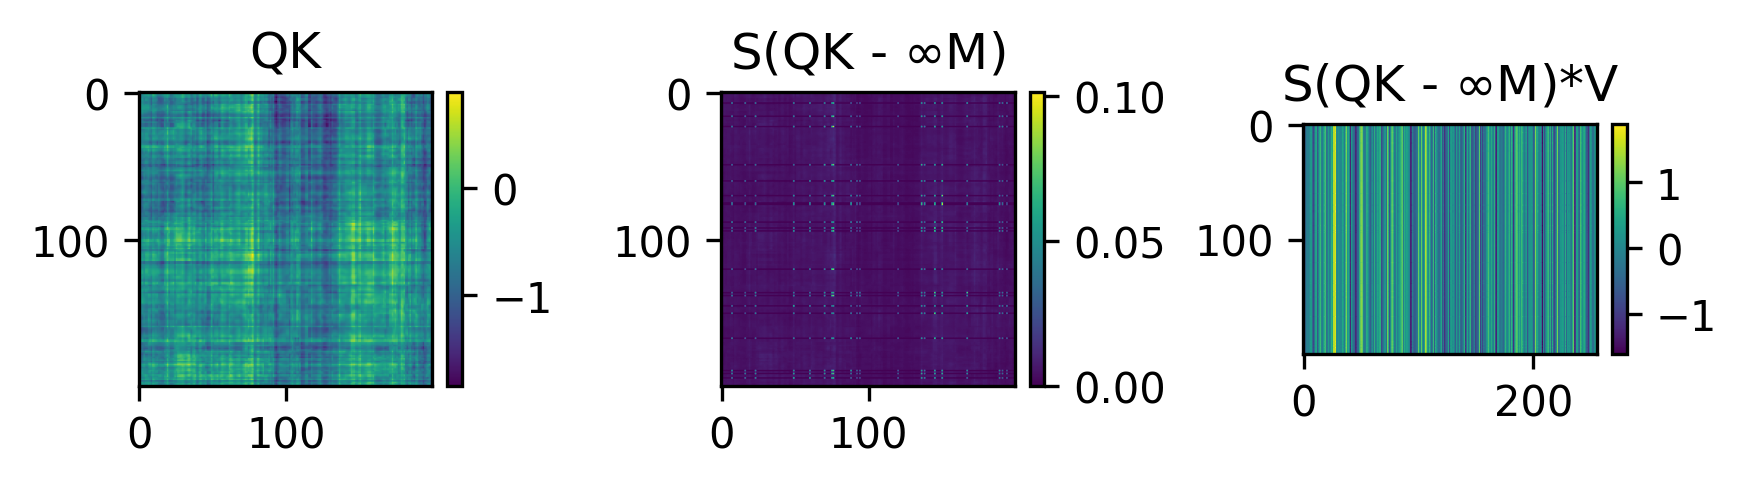

In [9]:
fig, axes = plt.subplots(1, 3, gridspec_kw={'wspace':0.8}, dpi=300)
im0 = axes[0].imshow(qkvalues[0, 0])
im1 = axes[1].imshow(w[0, 0])
im2 = axes[2].imshow(attn_output[0])

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

axes[0].set_title('QK')
axes[1].set_title(r'S(QK - $\infty$M)')
axes[2].set_title('S(QK - $\infty$M)*V')

(array([3.6000e+03, 2.6000e+01, 1.8980e+03, 7.3290e+03, 1.1095e+04,
        8.8810e+03, 4.1000e+03, 1.6780e+03, 6.2600e+02, 2.3900e+02,
        9.3000e+01, 2.3000e+01, 9.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00, 3.0000e+00,
        2.0000e+00, 7.0000e+00, 5.0000e+00, 5.0000e+00, 9.0000e+00,
        5.0000e+00, 7.0000e+00, 1.1000e+01, 1.0000e+01, 4.0000e+00,
        1.1000e+01, 1.1000e+01, 7.0000e+00, 1.1000e+01, 8.0000e+00,
        1.3000e+01, 8.0000e+00, 8.0000e+00, 7.0000e+00, 1.5000e+01,
        1.4000e+01, 9.0000e+00, 6.0000e+00, 1.2000e+01, 5.0000e+00,
        9.0000e+00, 1.4000e+01, 1.6000e+01, 1.1000e+01, 7.0000e+00,
        7.0000e+00, 6.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00,
        4.0000e+00, 2.0000e+00, 1.0000e+01, 8.0000e+00, 4.0000e+00,
        5.0000e+00, 4.0000e+00, 7.0000e+00, 6.0000e+00, 3.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 3.00

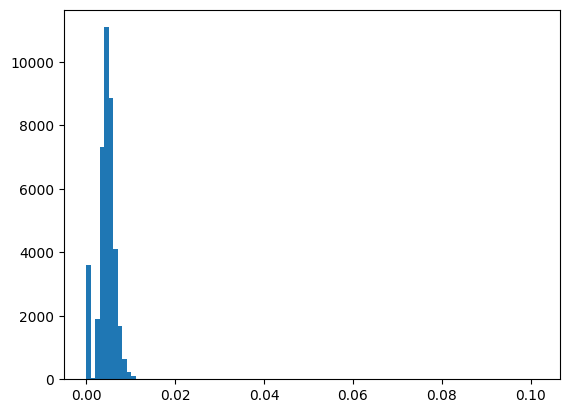

In [14]:
plt.hist(w[0, 0].numpy().flatten(), bins=100)